In [1]:
import torch
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import torch
from torch import nn
from torch import optim

from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from torchvision import models

import gc
from random import shuffle

/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# File paths
electron_file = "dataset/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
photon_file = "dataset/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"

In [3]:
# Load data files
electron_data = h5py.File(name = electron_file)
photon_data = h5py.File(name = photon_file)

In [4]:
electron_data.keys()

<KeysViewHDF5 ['X', 'y']>

In [5]:
# Feature shape
electron_data['X'].shape

(249000, 32, 32, 2)

In [6]:
# Target shape
electron_data['y'].shape

(249000,)

In [7]:
# Feature shape
photon_data['X'].shape

(249000, 32, 32, 2)

In [8]:
# Target shape
photon_data['y'].shape

(249000,)

In [9]:
# Target shape
photon_data['y'].shape

(249000,)

In [10]:
def h5_to_numpy(h5_file):
    X, y = h5_file["X"], h5_file["y"]
    return np.array(X), np.array(y)

In [11]:
electron_data = h5_to_numpy(electron_data)
photon_data = h5_to_numpy(photon_data)

In [12]:
data = np.concatenate([electron_data[0], photon_data[0]], axis = 0)
targets = np.concatenate([electron_data[1].reshape(-1, 1), photon_data[1].reshape(-1, 1)], axis = 0)

In [13]:
del electron_data
del photon_data

In [14]:
gc.collect()

6

In [15]:
targets.dtype

dtype('float32')

In [16]:
data[:10].shape

(10, 32, 32, 2)

In [17]:
np.unique(targets)

array([0., 1.], dtype=float32)

In [18]:
targets[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [19]:
targets[-20:]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [20]:
targets[::2]

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
y_train, y_test = train_test_split(pd.DataFrame(targets), test_size = .2, shuffle = True, stratify = targets)

In [23]:
train_indices = y_train.index.values

In [24]:
test_indices = y_test.index.values

In [25]:
train_indices

array([365729, 231079, 453318, ..., 483998,  48353, 135493])

In [26]:
test_indices

array([233115, 465060, 103456, ...,  93358, 407793, 311764])

In [27]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
data = torch.tensor(data).to(DEVICE)
targets = torch.tensor(targets, dtype = torch.int64).to(DEVICE)

In [29]:
# Split into train and test samples
train_data, test_data = data[train_indices], data[test_indices]
train_targets, test_targets = targets[train_indices], targets[test_indices]

In [30]:
del data
del targets

In [31]:
gc.collect()

11

In [32]:
# Generate train and test datasets
train_dataset = TensorDataset(train_data.permute(0, 3, 1, 2), train_targets)
test_dataset = TensorDataset(test_data.permute(0, 3, 1, 2), test_targets)

In [33]:
BATCH_SIZE = 128

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
gc.collect()

0

In [35]:
model = models.resnet18(pretrained=True)

/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
class ParticleModel(nn.Module):
    def __init__(self, model, freeze = False, out_features = 2, channels = 2, height = 32, width = 32):
        super().__init__()
        self.backbone = model
        self.freeze = freeze
        
        self.channels = channels
        self.height = height
        self.width = width

        self.out_features = out_features
        self.layer_norm = nn.LayerNorm([self.channels, self.height, self.width])

        if self.freeze:
            for param in self.backbone.parameters():
                param.requires_grad_(False)

        self.backbone.conv1 = nn.Conv2d(self.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        fc = nn.Linear(in_features=model.fc.in_features, out_features=self.out_features)
        
        self.backbone.fc = fc

    def forward(self, x):
        x = self.layer_norm(x)
        return self.backbone(x)

In [38]:
def initialize_weights(model):
    for (name, weights) in filter(lambda x: x[1].requires_grad, model.named_parameters()):
        if name.split(".")[1] not in ["fc", "conv1"]:
            continue
        try:
            nn.init.kaiming_normal_(weights)
        except:
            nn.init.normal_(weights, 0., 0.05)
    
    return model

def get_l2_loss(model):
    return sum([x ** 2 for x in model.parameters()])

In [39]:
model = ParticleModel(model = model)

In [40]:
model.to(DEVICE)

model = initialize_weights(model)

In [42]:
EPOCHS = 20
l2_lambda = 4e-4

criterion = nn.CrossEntropyLoss().to(DEVICE)

# Optimizer hyperparameters
LR = 1e-4
FACTOR = 100
AMSGRAD = False
BETAS = (.9, .999)

In this notebook, the pretrained weights will be finetuned. This is in contrast to the previous one, where the weights were kept frozen.

In [43]:
opt = optim.Adam(
    params = [{
        "params" : model.backbone.fc.parameters(),
        "lr": LR
    }],
    lr=LR/FACTOR,
    amsgrad = AMSGRAD,
    betas = BETAS
)

In [44]:
def get_l2_loss(model):
    l2_loss = torch.tensor(0.).cuda()
    l2_loss += sum(map(lambda x: x.pow(2).sum(), filter(lambda x: x.requires_grad, model.parameters())))
    return l2_loss

In [45]:
def collate_function_dl(batch):

    #xs = batch[0].clone()
    #ys = batch[1].clone()

    xs = [item[0].unsqueeze(0) for item in batch]
    ys = [item[1] for item in batch]
    
    xs = torch.cat(xs, dim=0)

    y = torch.tensor(ys).view(-1, 1)
    
    Xs = [torch.rot90(xs, k = _, dims = [-2, -1]) for _ in range(4)]

    return torch.cat(Xs, dim = 0), torch.cat([y for _ in range(4)], dim = 0).view(-1)

def collate_function(batch):

    xs = batch[0].clone()
    ys = batch[1].clone().view(-1, 1)
    
    Xs = [torch.rot90(xs, k = _, dims = [-2, -1]) for _ in range(4)]

    return torch.cat(Xs, dim = 0), torch.cat([ys for _ in range(4)], dim = 0).view(-1)

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
def training_loop(epochs, model, optimizer):
    TRAIN_LOSSES, TEST_LOSSES = [], []
    TRAIN_ACCS, TEST_ACCS = [], []

    for epoch in range(1, epochs + 1):
        train_losses, test_losses = [], []
        train_accs, test_accs = [], []

        model.train() # Set up training mode

        for batch in iter(train_dl):
            # X, y = collate_function(batch)
            X, y = batch
            X, y = X.to(DEVICE), y.view(-1).to(DEVICE)

            y_pred = model(X)
            # Uncomment the line below if the criterion is nn.NLLLoss()
            # y_pred = torch.log_softmax(y_pred, dim = -1)

            train_loss = criterion(y_pred, y) # Compare actual targets and predicted targets to get the loss
            train_loss.backward() # Backpropagate the loss
            
            optimizer.step()
            optimizer.zero_grad()

            train_losses.append(train_loss.item())

            train_acc = accuracy_score(y.cpu().numpy(), y_pred.max(dim = -1).indices.cpu().numpy())
            train_accs.append(train_acc)

        with torch.no_grad(): # Turn off computational graph
            model.eval() # Set model to evaluation mode
            for batch in iter(test_dl):
                # X_, y_ = collate_function(batch)
                X_, y_ = batch
                X_, y_ = X_.to(DEVICE), y_.view(-1).to(DEVICE)
    
                y_pred_ = model(X_)
                # Uncomment the line below if the criterion is nn.NLLLoss()
                # y_pred_ = torch.log_softmax(y_pred_, dim = -1)
    
                test_loss = criterion(y_pred_, y_) # Compare actual targets and predicted targets to get the loss
                test_losses.append(test_loss.item())

                test_acc = accuracy_score(y_.cpu().numpy(), y_pred_.max(dim = -1).indices.cpu().numpy())
                test_accs.append(test_acc)

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_test_loss = sum(test_losses) / len(test_losses)

        avg_train_acc = sum(train_accs) / len(train_accs)
        avg_test_acc = sum(test_accs) / len(test_accs)

        print(
            f"Epoch: {epoch} | Train loss: {avg_train_loss: .3f} | Test loss: {avg_test_loss: .3f} |",
            f"Train accuracy: {avg_train_acc: .3f} | Test accuracy: {avg_test_acc: .3f} |"
        )

        TRAIN_LOSSES.append(avg_train_loss)
        TEST_LOSSES.append(avg_test_loss)

        TRAIN_ACCS.append(avg_train_acc)
        TEST_ACCS.append(avg_test_acc)

    # Clear CUDA cache
    torch.cuda.empty_cache()
    torch.clear_autocast_cache()

    return {
        "loss": [TRAIN_LOSSES, TEST_LOSSES],
        "accuracy": [TRAIN_ACCS, TEST_ACCS],
        "model": model
    }

In [48]:
# Train Resnet-18 with finetuning
model_results = training_loop(epochs = EPOCHS, optimizer = opt, model = model)

/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706726118919/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1 | Train loss:  0.817 | Test loss:  0.723 | Train accuracy:  0.510 | Test accuracy:  0.517 |
Epoch: 2 | Train loss:  0.709 | Test loss:  0.699 | Train accuracy:  0.520 | Test accuracy:  0.524 |
Epoch: 3 | Train loss:  0.695 | Test loss:  0.692 | Train accuracy:  0.528 | Test accuracy:  0.534 |
Epoch: 4 | Train loss:  0.692 | Test loss:  0.690 | Train accuracy:  0.533 | Test accuracy:  0.536 |
Epoch: 5 | Train loss:  0.690 | Test loss:  0.689 | Train accuracy:  0.535 | Test accuracy:  0.539 |
Epoch: 6 | Train loss:  0.690 | Test loss:  0.689 | Train accuracy:  0.537 | Test accuracy:  0.539 |
Epoch: 7 | Train loss:  0.690 | Test loss:  0.690 | Train accuracy:  0.537 | Test accuracy:  0.533 |
Epoch: 8 | Train loss:  0.690 | Test loss:  0.689 | Train accuracy:  0.538 | Test accuracy:  0.537 |
Epoch: 9 | Train loss:  0.690 | Test loss:  0.691 | Train accuracy:  0.537 | Test accuracy:  0.534 |
Epoch: 10 | Train loss:  0.690 | Test loss:  0.689 | Train accuracy:  0.538 | Test accuracy

In [49]:
def visualize_results(history, key = None):
    if key is not None:
        TRAIN_RESULTS, TEST_RESULTS = history[key]

        plt.figure(figsize = (10, 3))

        plt.plot(range(EPOCHS), TRAIN_RESULTS, label = f"Training {key.capitalize()}")
        plt.plot(range(EPOCHS), TEST_RESULTS, label = f"Test {key.capitalize()}")

        plt.xlabel("Epochs")
        plt.ylabel(key.capitalize())

        plt.title(key.capitalize() + " Evolution for Train and Test Splits", fontsize = 16)

        plt.legend()
        plt.show(); plt.close("all")
    else:
        TRAIN_LOSSES, TEST_LOSSES = history["loss"]
        TRAIN_ACCS, TEST_ACCS = history["accuracy"]

        fig, ax = plt.subplots(1, 2, figsize = (15, 4))

        ax[0].plot(range(EPOCHS), TRAIN_LOSSES, label = "Training Loss")
        ax[0].plot(range(EPOCHS), TEST_LOSSES, label = "Test Loss")

        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")

        ax[0].set_title("Loss Evolution for Train and Test Splits", fontsize = 16)

        ax[1].plot(range(EPOCHS), TRAIN_ACCS, label = "Training Accuracy")
        ax[1].plot(range(EPOCHS), TEST_ACCS, label = "Test Accuracy")

        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy")

        ax[1].set_title("Accuracy Evolution for Train and Test Splits", fontsize = 16)

        plt.legend()
        plt.show(); plt.close("all")

    return

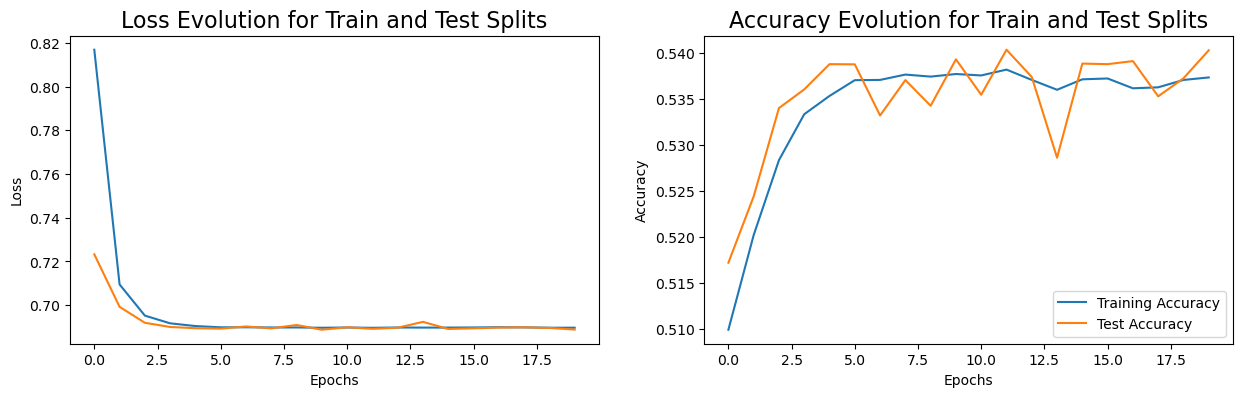

In [50]:
# VGG-13 with finetuning
visualize_results(model_results)